# Compare to the Lane et al 

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 150

In [3]:
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [4]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [5]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

# assert (data_dir / f"RUNOFF/models/{EXPERIMENT}").exists()
assert (data_dir / f"RUNOFF/features/{TRUE_EXPERIMENT}").exists()

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / f'RUNOFF/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}')

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

ds['station_id'] = ds['station_id'].astype(int)

In [7]:
# 13 test stations
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

# Open FUSE Models

In [8]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

# NOTE: only test performance on 2004-2008

In [9]:
fuse_ds = fuse_ds.sel(time=slice('2004-01-01', '2009-01-01'))
fuse_ds

<xarray.Dataset>
Dimensions:          (station_id: 841, time: 1827)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...

In [10]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["target_var_original"]
).rename("discharge_spec")

In [11]:
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

# Hydrographs

In [12]:
df = fuse_data.sel(time=(fuse_data['time.year'] == 2008).values).isel(station_id=10).to_dataframe().drop('station_id', axis=1)
df = df[["discharge_spec"] + [c for c in df.columns if "spec" not in c]]

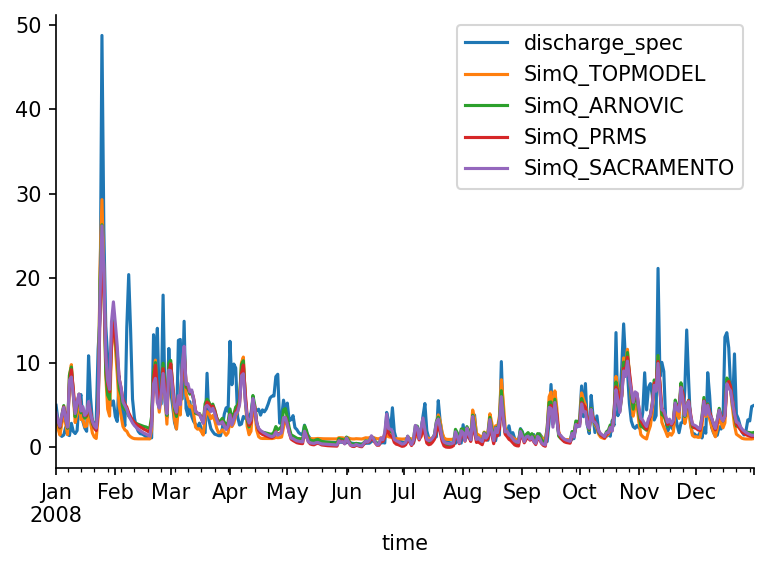

In [13]:
station_id = int(fuse_data.isel(station_id=10).station_id.values)
df.plot()
ax = plt.gca()
ax.set_title(f"Station {station_id}: 2008 Simulated and Observed Discharge")
sns.despine()

In [14]:
fuse_data = fuse_data.rename({'discharge_spec': 'obs'})
fuse_data.to_netcdf(data_dir / 'RUNOFF/fuse_data.nc')

# 13 Catchments

In [15]:
from typing import (Tuple, Dict, Optional, List, Union, Any)

def remove_invalid_vals(x, y) -> Tuple[np.ndarray, np.ndarray]:
    """check for infinite or nan values
    
    Required for np.polyfit:
    https://stackoverflow.com/a/13693657/9940782
    """
    isfinite = np.isfinite(y) & np.isfinite(x)
    notnull = pd.notnull(y) & pd.notnull(x)
    
    x = x[isfinite & notnull]
    y = y[isfinite & notnull]
    
    return x, y
    

def plot_1_1_line(x: np.ndarray, ax) -> plt.Axes:
    # plot 1:1 line
    line_1_1_x = np.linspace(x.min(), x.max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line', alpha=0.5)
    return ax


def plot_scatter(x: np.ndarray, y: np.ndarray, ax, one_to_one: bool = True, **kwargs) -> plt.Axes:
    """Scatter plot of x vs. y"""
    # plot scatter
    ax.plot(x, y, 'kx', **kwargs)
    
    if one_to_one:
        # plot 1:1 line
        ax = plot_1_1_line(x, ax)

    return ax


def plot_reg_line(x: np.ndarray, y: np.ndarray, ax, auto_label: bool = True, **kwargs):
    """plot linear regression line of x vs. y"""
    # plot regression line
    x, y = remove_invalid_vals(x, y)
    m, b = np.polyfit(x, y, 1)
    reg = (m * x + b)
    if auto_label:
        label = f'Regression Line: {m:.2f}X + {b:.2f}'
        ax.plot(x, reg, label=label, **kwargs)
    else:
        ax.plot(x, reg, **kwargs)

    return ax


def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None
):
    # select station & data
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    x = d[target_var]
    y = d.preds
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    kwargs = dict(alpha=0.6, label='Data Point')
    ax = plot_scatter(x, y, ax, **kwargs)

    # plot regression line
    kwargs = dict(color = '#7bd250', ls='--')
    ax = plot_reg_line(x, y, ax=ax, **kwargs)

    # make the plot pretty
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    if 'month' in df.columns:
        df = df.drop(columns='month')
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

In [16]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [17]:
fuse_13 = fuse_data.sel(station_id=np.isin(fuse_data['station_id'], catchment_ids))

In [18]:
fuse_13

<xarray.Dataset>
Dimensions:          (station_id: 13, time: 1827)
Coordinates:
  * station_id       (station_id) int64 12002 15006 27009 ... 54057 71001 84013
  * time             (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (time, station_id) float64 ...

# Errors

In [19]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse, spatial_bias
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

In [20]:
obs = fuse_data["obs"].transpose("station_id", "time")
topmodel = fuse_data["SimQ_TOPMODEL"]
arnovic = fuse_data["SimQ_ARNOVIC"]
prms = fuse_data["SimQ_PRMS"]
sacramento = fuse_data["SimQ_SACRAMENTO"]

## NSE

In [22]:
top_nse = spatial_nse(obs, topmodel).rename("TOPMODEL")
vic_nse = spatial_nse(obs, arnovic).rename("VIC")
prms_nse = spatial_nse(obs, prms).rename("PRMS")
sac_nse = spatial_nse(obs, sacramento).rename("Sacramento")

In [23]:
nse = xr.merge([
    top_nse,
    vic_nse,
    prms_nse,
    sac_nse,
])
nse_df = nse.to_dataframe()
nse_df = static['gauge_name'].to_dataframe().join(nse_df).rename(columns=dict(gauge_name="Name"))
nse_df.to_csv(data_dir / 'RUNOFF/FUSE_nse_table.csv')
nse_df.columns = [["nse" for _ in range(len(nse_df.columns))], nse_df.columns]


In [24]:
top_rmse = spatial_rmse(obs, topmodel).rename("TOPMODEL")
vic_rmse = spatial_rmse(obs, arnovic).rename("VIC")
prms_rmse = spatial_rmse(obs, prms).rename("PRMS")
sac_rmse = spatial_rmse(obs, sacramento).rename("Sacramento")

rmse = xr.merge([
    top_rmse,
    vic_rmse,
    prms_rmse,
    sac_rmse,
])
rmse_df = rmse.to_dataframe().drop(columns='time')
rmse_df.to_csv(data_dir / 'RUNOFF/FUSE_rmse_table.csv')
rmse_df.columns = [["rmse" for _ in range(len(rmse_df.columns))], rmse_df.columns]


In [25]:
top_r2 = spatial_r2(obs, topmodel).rename("TOPMODEL")
vic_r2 = spatial_r2(obs, arnovic).rename("VIC")
prms_r2 = spatial_r2(obs, prms).rename("PRMS")
sac_r2 = spatial_r2(obs, sacramento).rename("Sacramento")

r2 = xr.merge([
    top_r2,
    vic_r2,
    prms_r2,
    sac_r2,
])
r2_df = r2.to_dataframe().drop(columns='time')
r2_df.to_csv(data_dir / 'RUNOFF/FUSE_r2_table.csv')
r2_df.columns = [["r2" for _ in range(len(r2_df.columns))], r2_df.columns]

In [26]:
top_bias = spatial_bias(obs, topmodel).rename("TOPMODEL")
vic_bias = spatial_bias(obs, arnovic).rename("VIC")
prms_bias = spatial_bias(obs, prms).rename("PRMS")
sac_bias = spatial_bias(obs, sacramento).rename("Sacramento")

bias = xr.merge([
    top_bias,
    vic_bias,
    prms_bias,
    sac_bias,
])
bias_df = bias.to_dataframe()
bias_df.to_csv(data_dir / 'RUNOFF/FUSE_bias_table.csv')
bias_df.columns = [["bias" for _ in range(len(bias_df.columns))], bias_df.columns]

In [27]:
fuse_errors = pd.concat([nse_df, rmse_df, r2_df, bias_df], axis=1)
try:
    fuse_errors = fuse_errors.drop('time', axis=1, level=1).swaplevel(axis=1).sort_index(axis=1)
except KeyError:
    pass
fuse_errors.to_csv(data_dir / 'RUNOFF/FUSE_errors.csv')
fuse_errors.to_pickle(data_dir / 'RUNOFF/FUSE_errors.pkl')

### 13 stations

In [28]:
fuse_13 = fuse_errors.loc[np.isin(fuse_errors.index, catchment_ids)]
fuse_13 = fuse_13.rename(columns=dict(nse="NSE", r2="R2", rmse="RMSE", catchment_name="Name"))
fuse_13.index.name = "Station ID"
fuse_13

NSE                                           \
                               Name  TOPMODEL       VIC      PRMS Sacramento   
Station ID                                                                     
12002                   Dee at Park  0.556630  0.633095  0.645595   0.648255   
15006              Tay at Ballathie  0.803730  0.892683  0.863550   0.879369   
27009               Ouse at Skelton  0.861834  0.889123  0.878628   0.900831   
27034         Ure at Kilgram Bridge  0.838496  0.845481  0.846080   0.850750   
27041       Derwent at Buttercrambe  0.745959  0.713918  0.781723   0.809577   
39001            Thames at Kingston  0.731836  0.734690  0.634762   0.818929   
39081               Ock at Abingdon  0.710893  0.812519  0.708910   0.823289   
43021            Avon at Knapp Mill  0.278183  0.841176  0.791659   0.797063   
47001           Tamar at Gunnislake  0.851288  0.861083  0.853336   0.858073   
54001             Severn at Bewdley  0.854216  0.861241  0.848889   0.903441   
54057          Severn at Haw Bridge  0.888451  0.862782  0.870411   0.911889   
71001          Ribble at Samlesbury  0.832278  0.832930  0.831588   0.843933   
84013             Clyde at Daldowie  0.898075  0.891100  0.870042   0.905927   

                RMSE                                       R2            \
            TOPMODEL       VIC      PRMS Sacramento  TOPMODEL       VIC   
Station ID                                                                
12002       1.275403  1.160222  1.140287   1.136000  0.559234  0.633194   
15006       1.334686  0.986927  1.112856   1.046360  0.848050  0.912829   
27009       0.593983  0.532102  0.556716   0.503225  0.874982  0.906809   
27034       1.794398  1.755163  1.751756   1.724981  0.847607  0.851682   
27041       0.354790  0.376500  0.328869   0.307170  0.908834  0.918958   
39001       0.273695  0.272234  0.319414   0.224901  0.969899  0.975717   
39081       0.349947  0.281807  0.351145   0.273593  0.946692  0.971825   
43021       0.480858  0.225560  0.258339   0.254967  0.851653  0.974415   
47001       0.956466  0.924427  0.949856   0.934389  0.851618  0.861169   
54001       0.460012  0.448792  0.468342   0.374378  0.899781  0.917247   
54057       0.343897  0.381417  0.370663   0.305640  0.942288  0.940299   
71001       1.505523  1.502596  1.508619   1.452274  0.839439  0.837231   
84013       0.795793  0.822574  0.898589   0.764525  0.899062  0.891180   

                                      bias                                   
                PRMS Sacramento   TOPMODEL        VIC       PRMS Sacramento  
Station ID                                                                   
12002       0.645722   0.649310  -5.942977   7.123732  -3.035800  -7.205577  
15006       0.891123   0.905517  -8.805878   7.224393  -7.013328  -8.619510  
27009       0.894893   0.911684   3.980303   8.811956   3.035358   3.375319  
27034       0.853166   0.858565  -6.602561  -3.456757  -0.921798  -9.449231  
27041       0.932479   0.935457   1.412459  20.457355  10.312414  10.898775  
39001       0.963957   0.980663  16.526875  17.653984  46.282385  21.184702  
39081       0.952817   0.968999 -11.849456 -10.369773  -5.997321 -16.376295  
43021       0.963287   0.960704  33.324338  13.060202  15.555114   6.302035  
47001       0.853337   0.858202  -5.974199  14.790210  -2.664355  -4.217859  
54001       0.904800   0.935760  18.927446   7.134334  13.466011  11.820826  
54057       0.939799   0.956243   7.810071   8.877016   3.802692   2.524775  
71001       0.836930   0.849919   0.833191   4.358927   0.327128  -1.967546  
84013       0.870426   0.906555   1.668957  15.913328   7.981717   2.600944

In [29]:
print(fuse_13.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{5}{l}{NSE} & \multicolumn{4}{l}{RMSE} & \multicolumn{4}{l}{R2} & \multicolumn{4}{l}{bias} \\
{} &                     Name & TOPMODEL &  VIC & PRMS & Sacramento & TOPMODEL &  VIC & PRMS & Sacramento & TOPMODEL &  VIC & PRMS & Sacramento & TOPMODEL &    VIC &  PRMS & Sacramento \\
Station ID &                          &          &      &      &            &          &      &      &            &          &      &      &            &          &        &       &            \\
\midrule
12002      &              Dee at Park &     0.56 & 0.63 & 0.65 &       0.65 &     1.28 & 1.16 & 1.14 &       1.14 &     0.56 & 0.63 & 0.65 &       0.65 &    -5.94 &   7.12 & -3.04 &      -7.21 \\
15006      &         Tay at Ballathie &     0.80 & 0.89 & 0.86 &       0.88 &     1.33 & 0.99 & 1.11 &       1.05 &     0.85 & 0.91 & 0.89 &       0.91 &    -8.81 &   7.22 & -7.01 &      -8.62 \\
27009      &          Ouse at Skelton &     0.86 & 0.89 & 0

In [30]:
nse_df.columns

MultiIndex([('nse',       'Name'),
            ('nse',   'TOPMODEL'),
            ('nse',        'VIC'),
            ('nse',       'PRMS'),
            ('nse', 'Sacramento')],
           )

# distribution of errors

In [31]:
nse_df.columns = ["Name", "TOPMODEL", "VIC", "PRMS", "Sacramento"]
nse_df.to_csv(data_dir / "RUNOFF/FUSE_nse_all_stations.csv")

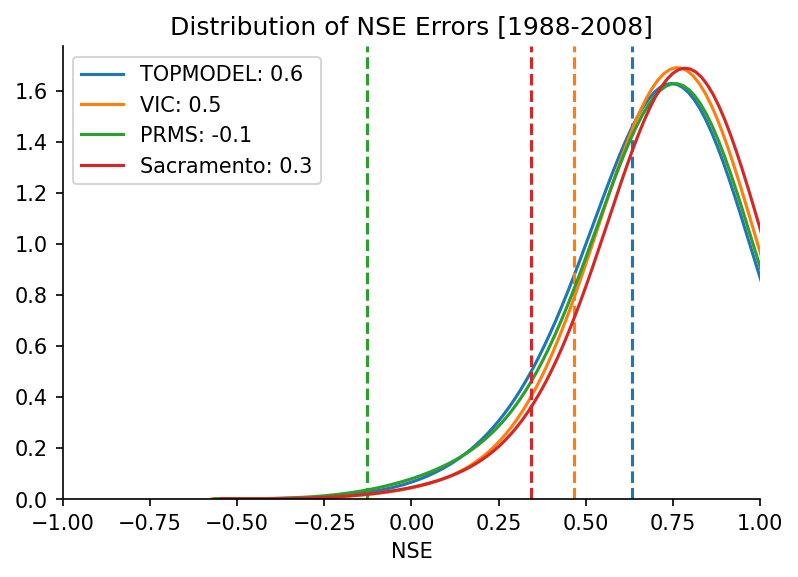

In [32]:
fig, ax = plt.subplots()
colors = sns.color_palette()

for ix, model in enumerate([c for c in nse_df.columns if c != "Name"]):
    sns.kdeplot(nse_df[model], ax=ax, label=f"{model}: {nse_df[model].mean():.1f}", bw=0.2, clip=(0, 1), color=colors[ix])
    ax.axvline(nse_df[model].mean(), ls='--', color=colors[ix])

ax.set_xlim([-1, 1])
ax.set_xlabel('NSE')

ax.set_title("Distribution of NSE Errors [1988-2008]")
sns.despine()

# Open the Less Vars experiments (2004-2015 test)

In [33]:
print([d.name for d in (data_dir/'runs/').iterdir()])
print([d.name for d in (data_dir/'runs').glob('*_less_vars*/*E015.csv')])

['ealstm_less_vars_2004_1607_1334', 'lstm_less_vars_1307_1717', 'ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p']
['results_lstm_less_vars_1307_1717_E015.csv', 'results_ealstm_less_vars_2004_1707_1424_E015.csv', 'results_lstm_less_vars_2004_1507_1028_E015.csv']


In [34]:
# lstm_less_vars = pd.read_csv(data_dir / "RUNOFF/lstm_less_vars/results_lstm_less_vars_1307_1717_E015.csv")
lstm_less_vars = pd.read_csv(data_dir / "runs/lstm_less_vars_2004_1507_1028/results_lstm_less_vars_2004_1507_1028_E015.csv")
# lstm_less_vars = lstm_less_vars[["station_id", "time", "obs", "sim_E015"]].rename(columns=dict(sim_E015="sim"))
lstm_less_vars["time"] = pd.to_datetime(lstm_less_vars["time"])

In [35]:
ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
ealstm_less_vars["time"] = pd.to_datetime(ealstm_less_vars["time"])

In [36]:
lstm_preds = lstm_less_vars.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_less_vars.set_index(["station_id", "time"]).to_xarray()

In [37]:
# all_lstm = pd.read_csv(data_dir/"RUNOFF/less_vars_2004_2015/all_lstm_less_vars_2004_1507_1028_results.csv")
# all_ealstm = pd.read_csv(data_dir/"RUNOFF/less_vars_2004_2015/results_ealstm_less_vars_2004_1707_1424_E011.csv")

In [38]:
lstm_df = lstm_less_vars
lstm_df["time"] = pd.to_datetime(lstm_df["time"])
ealstm_df = ealstm_less_vars
ealstm_df["time"] = pd.to_datetime(ealstm_df["time"])

lstm_preds = lstm_df.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_df.set_index(["station_id", "time"]).to_xarray()

In [39]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [40]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
]
ealstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
]
lstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

# Get Static data Table

In [41]:
hydrologic_attributes = [
    "gauge_name",
    "q_mean",
    "runoff_ratio",
    "stream_elas",
    "slope_fdc",
    "baseflow_index",
    "baseflow_index_ceh",
    "hfd_mean",
    "Q5",
    "Q95",
    "high_q_freq",
    "high_q_dur",
    "low_q_freq",
    "low_q_dur",
]

rename = dict(zip(
    hydrologic_attributes,
    [
        "Name",
        "Mean Discharge (Q) ($mm^{-3} day^{-1}$)",
        "Runoff Ratio",
        "Stream elasticity",
        "Slope of the Flow-Duration-Curve",
        "Baseflow Index",
        "Baseflow Index CEH",
        "hfd_mean",
        "Q5 Discharge ($mm^{-3} day^{-1}$)",
        "Q95 Discharge ($mm^{-3} day^{-1}$)",
        "High Discharge (Q) Frequency",
        "High Discharge (Q) Duration",
        "Low Discharge (Q) Frequency",
        "Low Discharge (Q) Duration",
    ]
))

In [42]:
print(
    static[hydrologic_attributes]
    .sel(station_id=np.isin(static["station_id"], catchment_ids))
    .to_dataframe()
    .rename(columns=rename)
    .to_latex(float_format="%.2f")

)

\begin{tabular}{llrrrrrrrrrrrrr}
\toprule
{} &                     Name &  Mean Discharge (Q) (\$mm\textasciicircum \{-3\} day\textasciicircum \{-1\}\$) &  Runoff Ratio &  Stream elasticity &  Slope of the Flow-Duration-Curve &  Baseflow Index &  Baseflow Index CEH &  hfd\_mean &  Q5 Discharge (\$mm\textasciicircum \{-3\} day\textasciicircum \{-1\}\$) &  Q95 Discharge (\$mm\textasciicircum \{-3\} day\textasciicircum \{-1\}\$) &  High Discharge (Q) Frequency &  High Discharge (Q) Duration &  Low Discharge (Q) Frequency &  Low Discharge (Q) Duration \\
station\_id &                          &                                          &               &                    &                                   &                 &                     &           &                                    &                                     &                               &                              &                              &                             \\
\midrule
12002      &             

In [43]:
# sns.palplot(sns.color_palette())

In [45]:
# station_id = "12002"
# d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
# seasons = ds.sel(time=d.index)["time.season"].values
# d["season"] = seasons
# d.head()

# Plot the Scatter Plot and Time Series Errors

In [46]:
def plot_station_scatter(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None,
    color_by_season: bool = None,
):
    # select station
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    if not color_by_season:
        # plot scatter
        ax.plot(d[target_var], d.preds, 'kx', alpha=0.6, label='Data Point')
    else:
        seasons = ds.sel(time=d.index)["time.season"].values
        d["season"] = seasons
        for ix, season in enumerate(d.season.unique()):
            ax.scatter(
                d.loc[d["season"] == season, target_var], 
                d.loc[d["season"] == season, "preds"], 
                color=sns.color_palette()[ix], 
                alpha=0.6, 
                label=season,
                marker="x"
            )
            sns.regplot(
                d.loc[d["season"] == season, target_var], 
                d.loc[d["season"] == season, "preds"], 
                color=sns.color_palette()[ix],
                ax=ax,
                scatter=False,
                ci=None,
            )
    # plot 1:1 line
    line_1_1_x = np.linspace(d[target_var].min(), d[target_var].max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    ax.set_xlabel('Observed $[mm d^{-1} km^{-2}]$')
    ax.set_ylabel('Predicted $[mm d^{-1} km^{-2}]$')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

In [47]:
# fig, ax = plt.subplots()
# plot_station_scatter(df, station_id, metrics_df, ax, color_by_season=True)

In [77]:
df = lstm_less_vars.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1)
metrics_df = lstm_df

# test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']
catchment_ids = ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]

plot_years = [2011]
scale = 0.8

def plot_catchment_time_series(
    df: pd.DataFrame,
    metrics_df: pd.DataFrame,
    catchment_ids: List[str],
    catchment_names: List[str],
    plot_years: List[int] = [2011],
    scale: float = 0.8,
    color_by_season: bool = False,
):
    n_plots = len(catchment_ids)
    station_map = dict(zip(catchment_ids, catchment_names))
    fig, axs = plt.subplots(n_plots, 2, figsize=(12*scale, 6*scale*n_plots))

    for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    #     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
        try:
            plot_station(df, station_id, metrics_df, ax=axs[ix, 0], station_name=station_name, plot_years=plot_years)
            plot_station_scatter(df, station_id, metrics_df, axs[ix, 1], color_by_season=color_by_season)
        except IndexError:
            # the axes are one dimensional
            plot_station(df, station_id, metrics_df, ax=axs[0], station_name=station_name, plot_years=plot_years)
            plot_station_scatter(df, station_id, metrics_df, axs[1], color_by_season=color_by_season)
        except TypeError:
            print(f"** {station_name} data does not exist in the predictions! **")

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    return fig, axs

In [78]:
def get_error_df(model: str, fuse_errors: pd.DataFrame) -> pd.DataFrame:
    all_models = ["TOPMODEL", "VIC", "PRMS", "Sacramento"]
    assert model in all_models
    remove_models = [m for m in all_models if m != model]
    error_df = fuse_errors.drop(remove_models, axis=1, level=1).swaplevel(axis=1).sort_index(axis=1).droplevel(axis=1, level=0)
    rename_cols = pd.io.parsers.ParserBase({'names': error_df.columns})._maybe_dedup_names(error_df.columns)
    error_df.columns = [n if n != "nse" else "Name" for n in rename_cols]
    return error_df.rename({"nse.1": "nse"}, axis=1)


topmodel = fuse_data[["obs", "SimQ_TOPMODEL"]].to_dataframe().reset_index()
vic = fuse_data[["obs", "SimQ_ARNOVIC"]].to_dataframe().reset_index()
prms = fuse_data[["obs", "SimQ_PRMS"]].to_dataframe().reset_index()
sacramento = fuse_data[["obs", "SimQ_SACRAMENTO"]].to_dataframe().reset_index()

top_error = get_error_df("TOPMODEL", fuse_errors)
vic_error = get_error_df("VIC", fuse_errors)
prms_error = get_error_df("PRMS", fuse_errors)
sac_error = get_error_df("Sacramento", fuse_errors)

In [79]:
lstm_less_vars.head()

,station_id,time,obs,sim
0,1001,2004-01-01,9.16,10.026257
1,1001,2004-01-02,6.23,5.819096
2,1001,2004-01-03,5.60,5.267475
3,1001,2004-01-04,4.45,5.064303
4,1001,2004-01-05,4.46,5.131446


# Get the median basins etc.

In [80]:
assert (data_dir / "RUNOFF/all_nse.csv").exists()
assert (data_dir / "RUNOFF/all_bias.csv").exists()

all_nse = pd.read_csv((data_dir / "RUNOFF/all_nse.csv"))
all_bias = pd.read_csv((data_dir / "RUNOFF/all_bias.csv"))

all_nse.head()

,Station ID,Name,TOPMODEL,VIC,PRMS,Sacramento,EALSTM,LSTM,CLASSIC,JULES
0,12002,Dee at Park,0.556630,0.633095,0.645595,0.648255,0.858937,0.865083,0.55,0.51
1,15006,Tay at Ballathie,0.803730,0.892683,0.863550,0.879369,0.924273,0.940792,0.46,0.64
2,27009,Ouse at Skelton,0.861834,0.889123,0.878628,0.900831,0.883401,0.905292,0.80,0.69
3,27034,Ure at Kilgram Bridge,0.838496,0.845481,0.846080,0.850750,0.872704,0.854971,0.78,0.75
4,27041,Derwent at Buttercrambe,0.745959,0.713918,0.781723,0.809577,0.747545,0.838306,0.65,0.49


In [87]:
median = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].median()]
min_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].min()]
max_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].max()]

median_station = (median["Station ID"].values, median.Name.values)
min_station = (min_["Station ID"].values, min_.Name.values)
max_station = (max_["Station ID"].values, max_.Name.values)

pd.concat([median, min_, max_])

,Station ID,Name,TOPMODEL,VIC,PRMS,Sacramento,EALSTM,LSTM,CLASSIC,JULES
5,39001,Thames at Kingston,0.731836,0.734690,0.634762,0.818929,0.744352,0.866479,0.81,0.82
6,39081,Ock at Abingdon,0.710893,0.812519,0.708910,0.823289,0.428313,0.672750,0.80,-0.21
12,84013,Clyde at Daldowie,0.898075,0.891100,0.870042,0.905927,0.948111,0.946680,0.80,0.82


In [88]:
summary_stations = np.vstack([median_station, min_station, max_station]).reshape(3, 2)

# LSTM Errors

In [89]:
PLOT_ALL = False

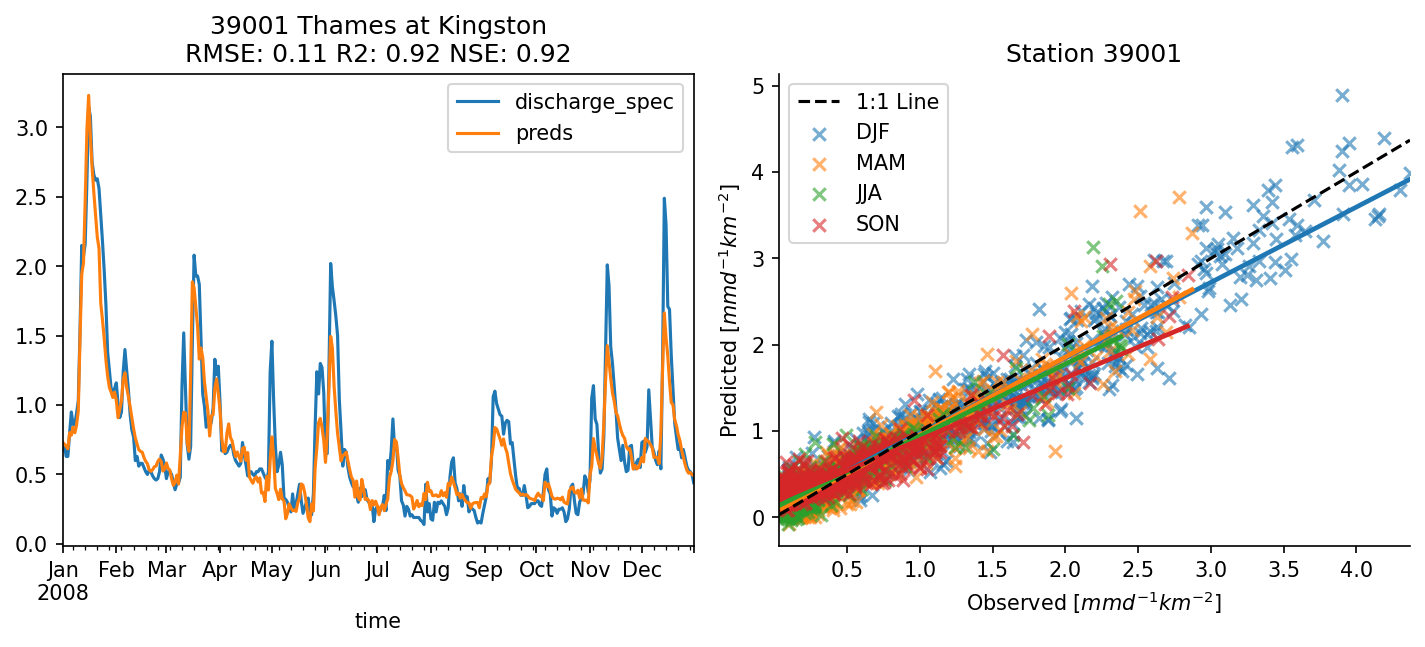

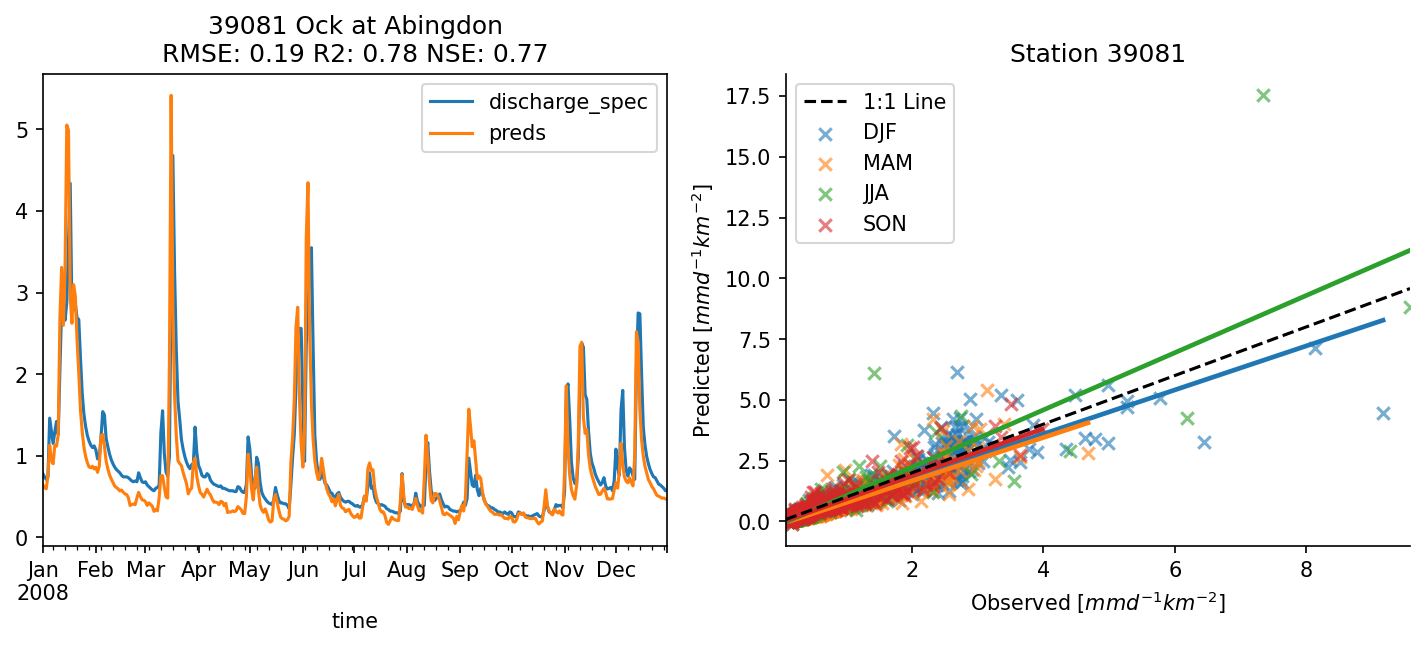

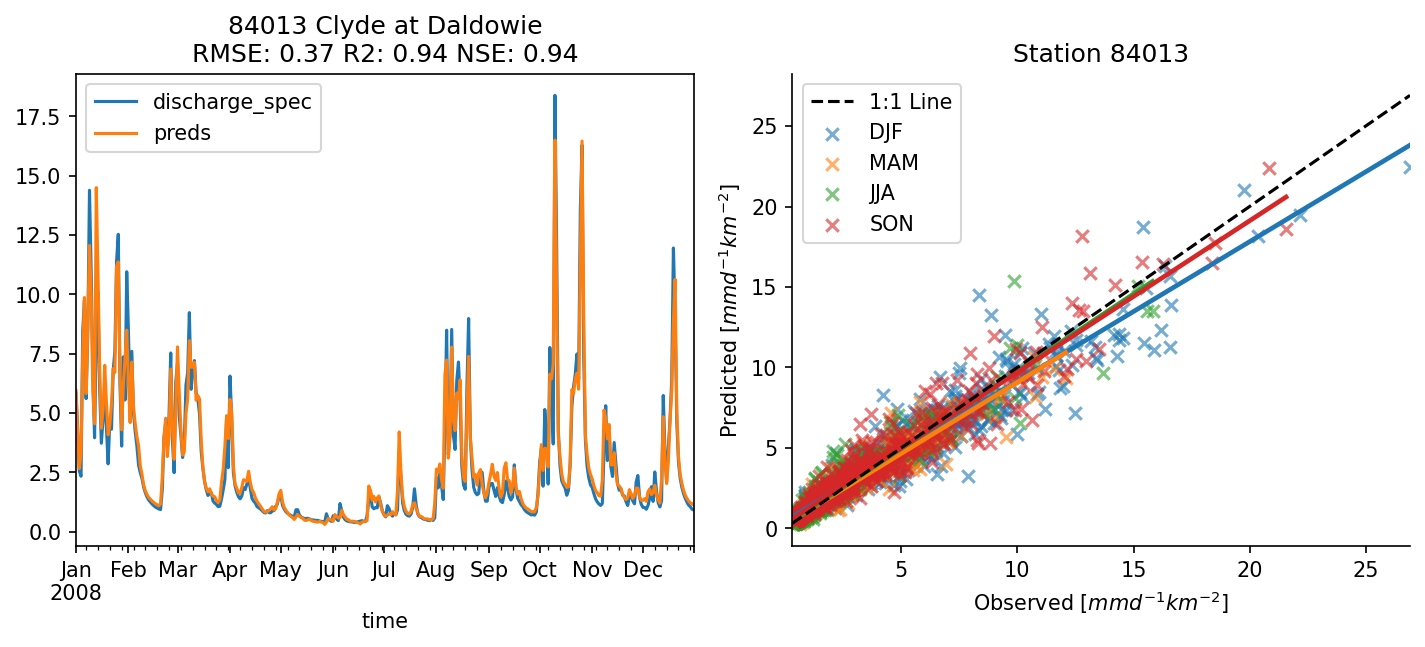

In [90]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=lstm_less_vars.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
        metrics_df=lstm_df,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    
else:
    for idx, name in summary_stations:
        fig, axs = plot_catchment_time_series(
            df=lstm_less_vars.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
            metrics_df=lstm_df,
            catchment_ids=[idx],
            catchment_names=[name],
            plot_years=[2008],
            color_by_season=True,
        );
    

# Conceptual Errors

In [64]:
if PLOT_ALL:

    fig, axs = plot_catchment_time_series(
        df=topmodel.set_index("time").rename({"obs": "discharge_spec", "SimQ_TOPMODEL": "preds"}, axis=1),
        metrics_df=top_error,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    fig.suptitle("TOPMODEL");

In [65]:
if PLOT_ALL:

    fig, axs = plot_catchment_time_series(
        df=sacramento.set_index("time").rename({"obs": "discharge_spec", "SimQ_SACRAMENTO": "preds"}, axis=1),
        metrics_df=sac_error,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    fig.suptitle("SACRAMENTO");

In [63]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=vic.set_index("time").rename({"obs": "discharge_spec", "SimQ_ARNOVIC": "preds"}, axis=1),
        metrics_df=vic_error,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    fig.suptitle("VIC");

In [62]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=prms.set_index("time").rename({"obs": "discharge_spec", "SimQ_PRMS": "preds"}, axis=1),
        metrics_df=prms_error,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    fig.suptitle("PRMS");

# Confirm the NSE calculations

In [ ]:
from src.analysis.evaluation import _nse_func

In [ ]:
lstm_less_vars.head()

In [ ]:
out = {}
for station in lstm_less_vars.station_id.unique():
    out[station] = _nse_func(
        lstm_less_vars.loc[lstm_less_vars["station_id"] == station, "obs"].values, 
        lstm_less_vars.loc[lstm_less_vars["station_id"] == station, "sim"].values
    )

In [ ]:
nse = pd.DataFrame(out, index=[0]).T.reset_index().rename({"index": "station_id", 0: "nse"}, axis=1)
nse

In [ ]:
display(nse.set_index("station_id")["nse"].head())
display(metrics_df.set_index("station_id")["nse"].head())